# Neoclassical Growth Model: solution via Value Function Iteration, Q-Learning and Deep Q-Learning

This notebook was created on the basis of my own code for VFI, and adapted from a notebook by Richard Galtings "Introduction to reinforcement learning" presented in the framework of the Math+Econ+Code masterclass in 2022.

In [ ]:
!pip3 install gym

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt
import matplotlib

import gym
import numpy as np
import math
import pandas as pd

# The Neoclassical Growth Model

This is a basic macroeconomic model in discrete time, infinite horizon. An agent maximizes its lifetime utility under budget constraint. The specification of the model presented here assumes complete depreciation of capital, but this is inconsequential.

\begin{align*}
\max_{\{c_t\}_0^\infty} &\sum_{t=0}^\infty \beta^t u(c_t)\\
\text{s.t } &c_t + k_{t+1} = f(k_t)\\
& k_0 \text{ given }
\end{align*}

Given the functional form chosen for our utility and production functions, this becomes:

\begin{align*}
\max_{\{c_t\}_0^\infty} &\sum_{t=0}^\infty \beta^t \log(c_t)\\
\text{s.t } &c_t + k_{t+1} = Ak_t^\alpha\\
&k_0 \text{ given }
\end{align*}

Which we can rewrite under unconstrained form:

\begin{align*}
\max_{\{k_{t+1}\}_{t=0}^\infty} \sum_{t=0}^\infty \beta^t \log(Ak_t^\alpha - k_{t+1}) \hspace{24pt} k_0 \text{ given }\\
\end{align*}


In this notebook, we will solve the problem using three different methods. The first one is classical value function iteration (VFI), which relies on the contraction mapping theorem to guarantee convergence.

The second one is one-agent Q-learning, in which an agent experiments with its environment following an $\epsilon$-greedy policy and determines the value of being in each state, based on the optimal action to take in each state. We note the similarity between VFI and Q-learning in that the "value_array" object constructed in VFI is identical to the $Q$ table constructed through Q-learning.

Finally, we experiment with neural networks by solving the problem through deep reinforcement learning. Instead of constructing an explicit $Q$ table, the deep Q-network (DQN) determines a linear approximation of the function $Q(s, a)$, which determines, after convergence, the optimal action to take in any state $s$.


In [1]:
class vfi_problem:
    def __init__(self, kmin:float, kmax:float, prec, A, alpha, beta):
        self.kmin = kmin
        self.kmax = kmax
        self.prec = prec

        self.A = A
        self.alpha = alpha

        self.beta = beta #discount factor

    def iterate(self, norm=1e5, tol=1e-6, maxiter=1000):
        kgrid = torch.linspace(self.kmin, self.kmax, self.prec).reshape(1, -1)
        n_iter = 0
        Qk = torch.ones((self.prec, 1))
        C_mat = self.A*(kgrid.T**self.alpha) - kgrid
        log_C_mat = torch.where(C_mat > 0, torch.log(C_mat), torch.tensor(-float('inf')))

        while n_iter < maxiter and norm > tol:
            value_array = log_C_mat + self.beta*Qk.T
            Qk_ = torch.max(value_array, dim=1).values.reshape(-1, 1)
            norm = torch.max(torch.abs(Qk_ - Qk))
            Qk = Qk_
            n_iter += 1
            if n_iter % 10 == 0:
              print("iteration: ", n_iter, " norm: ", norm.item())

        if n_iter < maxiter:
            print(f"Convergence reached after {n_iter} iterations.")
        else:
            print(f"Hit maximum iterations after {n_iter} iterations.")

        kgrid = kgrid.flatten()
        gk = kgrid[torch.argmax(value_array, dim=1).flatten()]
        kstar = kgrid[torch.argmin(torch.abs(gk - kgrid))]
        print(f"The steady-state value of capital is {kstar}")
        return kgrid, gk, kstar

In [ ]:
vfi = vfi_problem(1, 25, 51, A=10, alpha=0.5, beta=0.5)
grid, policy, k_ss = vfi.iterate()

iteration:  10  norm:  0.004240989685058594
iteration:  20  norm:  4.76837158203125e-06
Convergence reached after 23 iterations.
The steady-state value of capital is 6.279999732971191


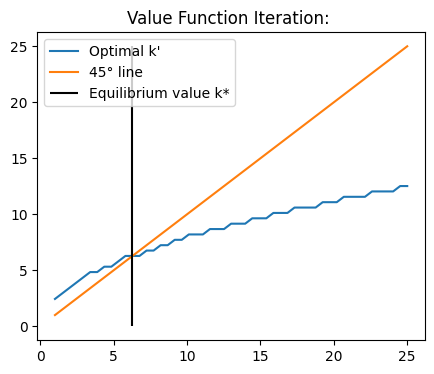

In [ ]:
plt.rcParams["figure.figsize"] = (5, 4)

plt.plot(grid, policy, label="Optimal k'")
plt.plot(grid, grid, label="45° line")
plt.vlines(k_ss, ymin=0, ymax=25, label="Equilibrium value k*", colors='black')

plt.title("Value Function Iteration: ")
plt.legend()
plt.savefig("vfipy.png")

# Q-Learning

In [ ]:
#Gym environment definition adapted from "Machine Learning for Economics with Tensorflow 2", Isaiah Hull
class planner(gym.Env):
    def __init__(self, prec=51):
        self.prec = prec
        self.kgrid = torch.linspace(1.0, 25.0, self.prec)
        self.action_space = gym.spaces.Discrete(self.prec)
        self.observation_space = gym.spaces.Discrete(self.prec)

        self.decision_count = 0
        self.decision_max = 100
        self.observation = int(self.prec/2)
        self.alpha = 0.5
        self.A = 10

    def step(self, action):
        assert self.action_space.contains(action)
        self.decision_count += 1
        done = False

        c = self.A*(self.kgrid[self.observation]**self.alpha) - self.kgrid[action]

        if c > 0:
            reward = torch.log(c)
        else:
            reward = -1000
            #reward = -1

        self.observation = action

        if (self.decision_count >= self.decision_max) or reward == -1000:
            done = True
        return self.observation, reward, done, {"decisions": self.decision_count}

    def reset(self):
        self.decision_count = 0
        self.observation = int(torch.multinomial(self.kgrid, 1).item())
        return self.observation

In [ ]:
env = planner(prec=51)
Q = torch.rand((env.observation_space.n, env.action_space.n))
maxiter = 10_000
alpha = 0.5

#discount factor
gamma = 0.5


epsilon = 0.95
epsilon_decay = 0.0001
tol = 0.001

buffer_size = 100
diff_buffer = torch.ones(buffer_size)*tol + 1
norm_h = []
norm = 1e6
n_iter = 0

while n_iter < maxiter and norm > tol:
    state = env.reset()
    done = False
    while not done:
        epsilon = max(epsilon, 0)

        if torch.rand(1) > epsilon:
            action = (Q[state]).argmax().item()
        else:
            action = env.action_space.sample()

        new_state, reward, done, info = env.step(action)
        TD = alpha * (reward + gamma*torch.max(Q[new_state]) - Q[state, action])
        Q[state, action] += TD
        diff_buffer[n_iter % buffer_size] = TD

        norm = torch.norm(diff_buffer)
        norm_h.append(norm)
        state = new_state
    epsilon -= epsilon_decay

    n_iter += 1
    if n_iter % 100 == 0:
      print(f"Iteration: {n_iter}, norm: {norm}")

Iteration: 100, norm: 4519.69091796875
Iteration: 200, norm: 3702.17236328125
Iteration: 300, norm: 2568.188720703125
Iteration: 400, norm: 2335.713134765625
Iteration: 500, norm: 1728.845458984375
Iteration: 600, norm: 1604.28125
Iteration: 700, norm: 1345.8018798828125
Iteration: 800, norm: 998.8740844726562
Iteration: 900, norm: 528.1912841796875
Iteration: 1000, norm: 791.8981323242188
Iteration: 1100, norm: 286.66864013671875
Iteration: 1200, norm: 320.487548828125
Iteration: 1300, norm: 183.5666961669922
Iteration: 1400, norm: 135.34645080566406
Iteration: 1500, norm: 125.50900268554688
Iteration: 1600, norm: 88.8260726928711
Iteration: 1700, norm: 97.62081146240234
Iteration: 1800, norm: 40.589717864990234
Iteration: 1900, norm: 48.921775817871094
Iteration: 2000, norm: 33.3469123840332
Iteration: 2100, norm: 41.77199935913086
Iteration: 2200, norm: 23.509531021118164
Iteration: 2300, norm: 18.977169036865234
Iteration: 2400, norm: 7.017505168914795
Iteration: 2500, norm: 18.791

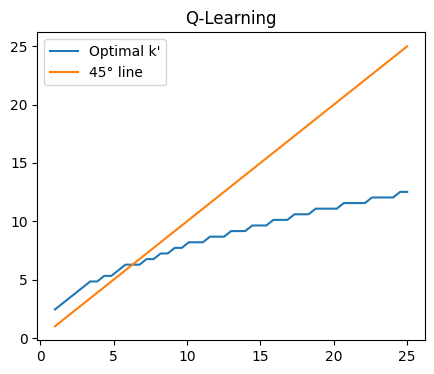

In [ ]:
plt.rcParams["figure.figsize"] = (5, 4)

grid = torch.linspace(1, 25, 51)
policy_q = grid[torch.argmax(Q, dim=1)]

plt.plot(grid, policy_q, label="Optimal k'")
plt.plot(grid, grid, label="45° line")
plt.title("Q-Learning")
plt.legend()
plt.show()

# Deep Q-learning

This implementation of the DQN algorithm is based on the following [Pytorch tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [ ]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [ ]:
class DQN(nn.Module):
    def __init__(self, nobs=1, hidden_size=64, n_actions=51):
        super(DQN, self).__init__()
        self.dropout = nn.Dropout(0.05)
        self.layer1 = nn.Linear(nobs, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        x = self.dropout(x)
        x = F.leaky_relu(self.layer1(x))
        x = F.leaky_relu(self.layer2(x))
        return self.layer3(x)

In [ ]:

def plot_reward(x, show_result=False):
    plt.rcParams["figure.figsize"] = (10, 5)
    plt.figure(1)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Lifetime Utility')
    plt.plot(x)

    if len(x) >= 100:
      means = torch.tensor(x).unfold(0, 100, 1).mean(1).view(-1)
      means = torch.cat((-1000.0*(torch.ones(99)), means))
      plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
torch.manual_seed(42)
prec_val = 51
env = planner(prec=prec_val)

maxiter = 5_000
alpha = 0.05
LR = 0.0001

#discount factor
gamma=0.5

eps_max = 1
eps_min = 0
tol = 0.01

buffer_size = 200
diff_buffer = torch.ones(buffer_size)*tol + 1
norm_h = []
norm = 1e6
n_iter = 0

#Huber Loss
criterion = nn.SmoothL1Loss()

#Deep Q Network
Qnet = DQN(hidden_size = 256, n_actions=prec_val).to(device)
opt_Q = optim.AdamW(Qnet.parameters(), lr=LR, amsgrad=True)
reward_f = []


while n_iter < maxiter and norm > tol:
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        obj = 0

        #Simple epsilon-greedy policy
        epsilon = (eps_min + (eps_max - eps_min)*torch.exp(torch.tensor([-1.0*n_iter/800]))).to(device)
        with torch.no_grad():
            k = env.kgrid[state].unsqueeze(0).to(device)
            if torch.rand(1).to(device) > epsilon:
                action = Qnet(k).argmax().item()
            else:
                action = env.action_space.sample()

            new_state, reward, done, info = env.step(action)
            total_reward += reward
            kp = env.kgrid[new_state].unsqueeze(0).to(device)


        #computes Temporal Difference
        TD1 = reward + gamma*torch.max(Qnet(kp).detach())
        TD2 = Qnet(k)[action]
        TD = alpha * (TD1 - TD2)
        obj += criterion(TD1, TD2)


        diff_buffer[n_iter % buffer_size] = TD

        #update network
        opt_Q.zero_grad()
        obj.backward()

        #gradient clipping
        torch.nn.utils.clip_grad_value_(Qnet.parameters(), 100)
        opt_Q.step()


        norm = torch.norm(diff_buffer)
        norm_h.append(norm.item())
        state = new_state

    n_iter += 1
    if n_iter % 100 == 0:
      print(f"Iteration: {n_iter}, norm: {norm}, epsilon: {epsilon.item()}, total reward: {total_reward}")
    reward_f.append(total_reward)

    plot_reward(reward_f)

<Figure size 1000x500 with 0 Axes>

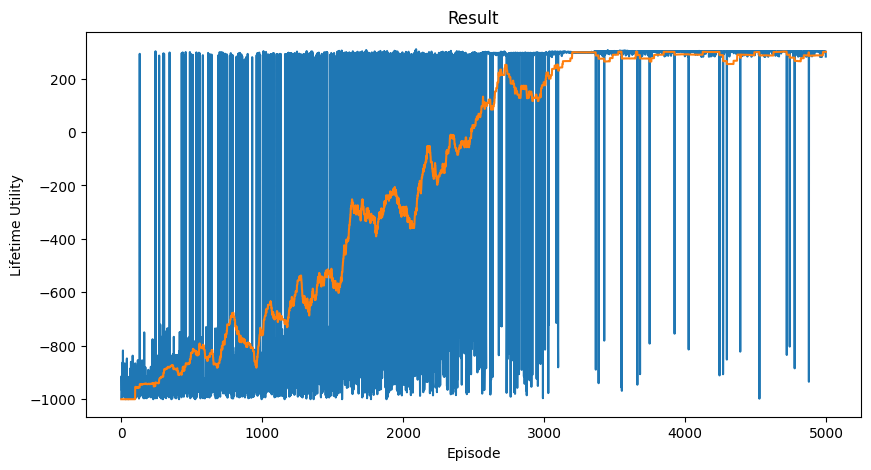

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [ ]:
plot_reward(reward_f, show_result=True)

In [ ]:
grid = env.kgrid

policy_deep_q = []
for kval in grid:
  policy_deep_q.append(grid[Qnet(torch.tensor([kval]).to(device)).argmax()])

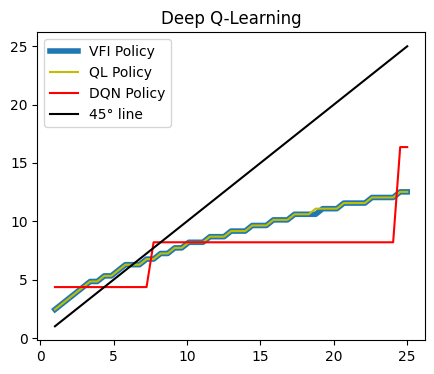

In [ ]:
plt.rcParams["figure.figsize"] = (5, 4)


plt.plot(grid, policy, label="VFI Policy", linewidth=4)
plt.plot(grid, policy_q, label= "QL Policy", c='y')
plt.plot(grid, policy_deep_q, label="DQN Policy", c='r')
plt.plot(grid, grid, label="45° line", c='black')
plt.title("Deep Q-Learning")
plt.legend()
plt.show()

# Results

While VFI and Q-learning method yield good approximations of the optimal policy function, the approximation obtained by deep Q-network is clearly less smooth.